## Widzenie Komputerowe - Projekt 2

# Bilard

Autorzy: Dariusz Max Adamski, Sławomir Gilewski, Anita Zielińska

---

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import colorsys
from math import pi
from time import time, sleep
from numpy import uint8 as u8
from tqdm.notebook import tqdm
from numpy.linalg import norm
from collections import defaultdict

plt.rc('grid', linewidth=0)
    
def argmin(xs):
    i = np.argmin(xs)
    return i, xs[i]

def dist(x1, x2, y1, y2):
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def stack3(x):
    return np.dstack([x]*3)

## UI helpers

def get_key(wait=False):
    return chr(cv.waitKey(int(not wait)) & 0xFF)

def cv_imshow(img, ax=plt):
    if len(img.shape) == 3:
        ax.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    else:
        ax.imshow(img, cmap='gray')
    
def cv_play(draw, *, path=None, pause=True):
    cv.destroyAllWindows()
    capture = cv.VideoCapture(path)
    try:
        skip = 0
        while capture.isOpened():
            _, frame = capture.read()
            if frame is None: break
            draw(frame)
            if skip > 0: skip -= 1; continue
            key = get_key(wait=pause)
            if key == ' ': pause = not pause
            if key == 'n': continue
            if key == 'f': skip = 2*30
            if key == 'q': break
    except Exception as e:
        raise e
    finally:
        cv.destroyAllWindows()
        capture.release()
        
def playnow(**args):
    def decorator(func):
        cv_play(func, **args)
    return decorator

## OpenCV helper functions 
    
def channels(img):
    return [img[:,:,i] for i in range(img.shape[2])]
    
def sharpen(img):
    kernel = np.array([[0, -1, 0], [-1,5,-1], [0,-1,0]])
    return cv.filter2D(img, -1, kernel)

def gaussian_blur(img, k=3):
    return cv.GaussianBlur(img, (k, k), 0)

def erode(img, k, iters=1):
    return cv.erode(img, np.ones((k, k)), iterations=iters)

def dilate(img, k, iters=1):
    return cv.dilate(img, np.ones((k, k)), iterations=iters)

def find_contours(mask):
    contours = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    return contours[0] if len(contours) == 2 else contours[1]

## Konfiguracja problemu

In [2]:
PATH = 'input.mp4'
FONT = cv.FONT_HERSHEY_SIMPLEX
BLU = (255,0,0)
GRN = (0,225,0)
RED = (0,0,255)
WHT = (255,255,255)
EPS = 1e-8
INF = 1e+8
tau = 2*pi

# krawędzie stołu i dziury
HA, HB = (154, 15), (532, 15)
HE, HF = (111, 155), (577, 155)
HC, HD = (52, 370), (646, 370)
HOLES = HA, HB, HC, HD, HE, HF

# punkt gdzie jest stawiana czarna bila
black_x, black_y, black_r = 345, 321, 10

## Funkcje pomocnicze dla problemu

In [3]:
# funkcja usuwająca czarne paski z filmiku
def crop_frame(img):
    return img[75:506, 124:822]

# funkcja rysująca obwódkę stołu, znaczniki dziur i status
def draw_overlay(img, status):
    H, W = img.shape[:2]
    cv.line(img, HA, HC, RED, 2)
    cv.line(img, HB, HD, RED, 2)
    cv.line(img, HA, HB, RED, 2)
    cv.line(img, HC, HD, RED, 2)
    for x in HOLES:
        cv.circle(img, x, 10, RED, -1, 8)
    cv.rectangle(img, (40, 400), (650, 450), 0, -1)
    cv.putText(img, status, (50, 420), FONT, 0.8, WHT, 2)
    
# funkcja zwracająca poszczególne klatki z klipu, usuwając czarne pasy 
def sample_video(path, frames):
    samples = []
    capture = cv.VideoCapture(path)
    i = 0
    for frame in frames:
        while i < frame:
            _, img = capture.read()
            i += 1
        samples += [crop_frame(img)]
    capture.release()
    return samples

# funkcja obliczająca okrągłość konturu: idealne pole / pole konturu
# idealne pole = pole koła gdzie promień to średnia z szerokości i wysokości bounding boxa / 2
def contour_roundness(c):
    xr, yr, w, h = rect = cv.boundingRect(c)
    r = (w+h)/4
    a_star = pi*r**2
    a = cv.contourArea(c)
    if a_star < EPS: return 0
    return 1 - abs(a - a_star)/a_star

# Segmentacja obrazu

### 1. Pozyskanie maski stołu ze znanych wierzchołków

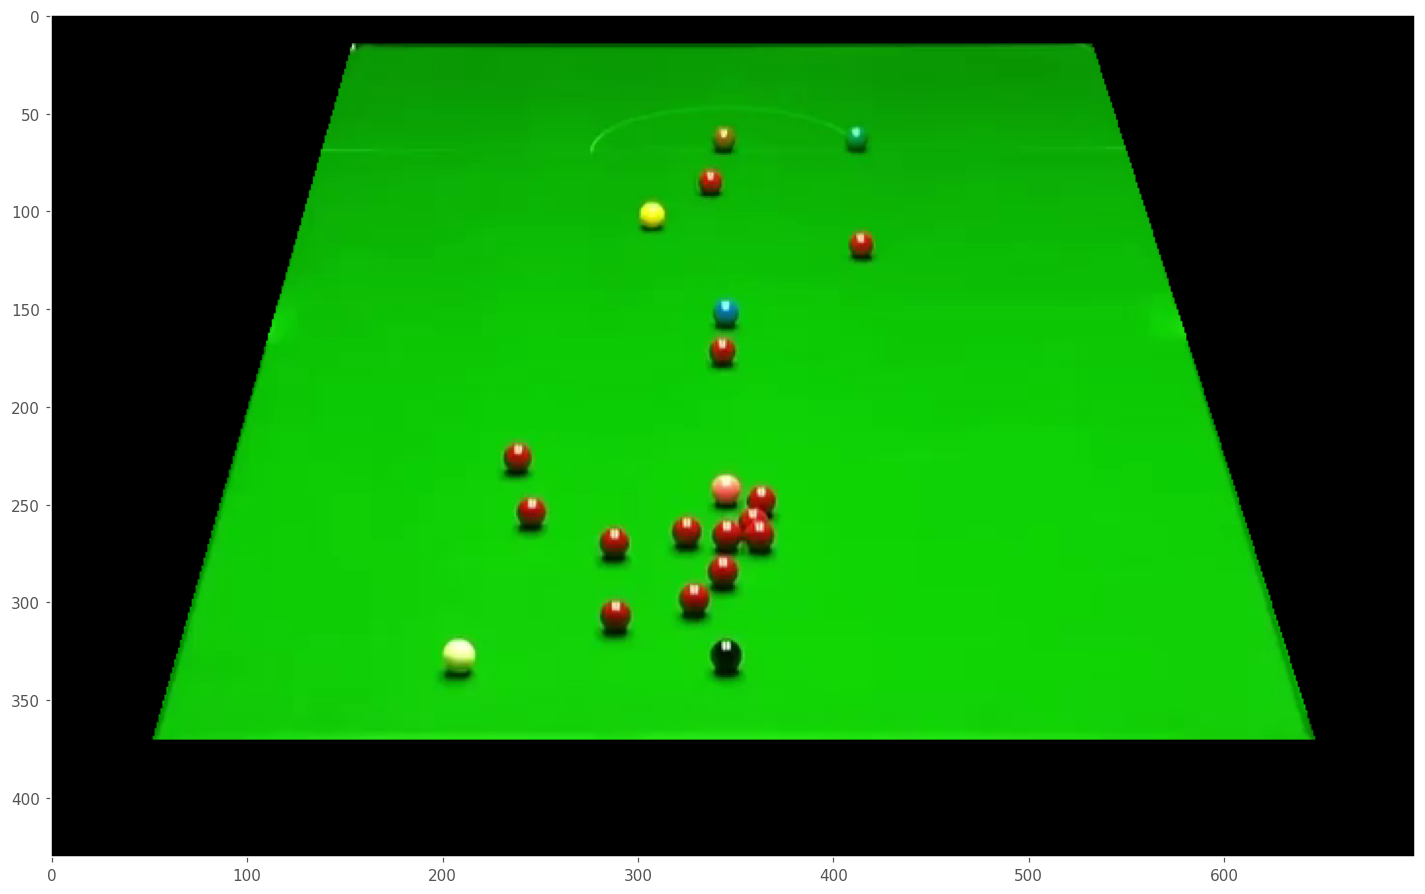

In [4]:
samples = sample_video(PATH, [1, 163, 236, 403, 1000])
first = samples[0]
H, W = first.shape[:2]
mask = np.zeros((H, W), dtype=np.uint8)
cv.fillConvexPoly(mask, np.array([HA, HC, HD, HB]), 1)
cv_imshow(first * np.dstack([mask]*3))

### 2. Pozyskanie maski bil przez progowanie 

- Na początku stosujemy rozmycie Gaussowskie (jądro 5x5) i wyostrzanie (splot z `[[0 -1 0] [-1 5 -1] [0 -1 0]]`).
- Konwertujemy klatkę do przestrzeni HSV i obliczamy maskę stołu (już teraz pozbywamy się ludzi) i czerwonych bil
- Dodajemy do maski stołu maskę czerwonych bil (żeby dodykający je czerwony kij wszystkich nie wykluczył z maski przy znajdywaniu kontur)
    - Jak kij dotknie bili z innego koloru niż czerwonego to ona zniknie z maski na jedną lub dwie klatki, ale to już nie jest problem, bo to max 1 bila
- Znajdujemy kontur stołu i zamykamy w nim dziury, czyli bile
- Następnie progujemy metodą Otsu kanał S z wyostrzonego obrazka i mnożymy razy ostateczną maskę stołu -> każda bila ma refleks świetlny
- Robimy drobną dylację górnej części maski bil bo póżniej będziemy filtrować kontury po wielkości, a dla uproszczenia nie korygujemy perspektywy stołu

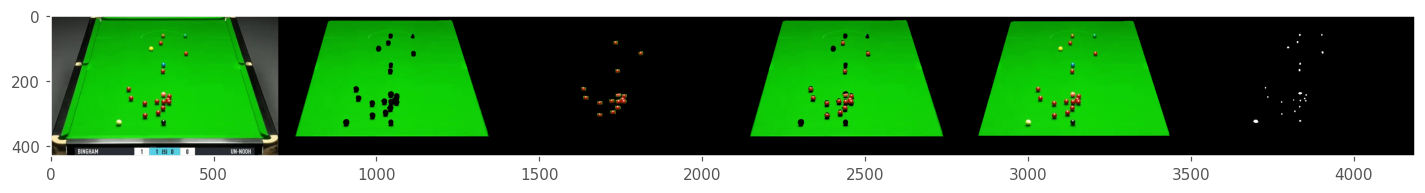

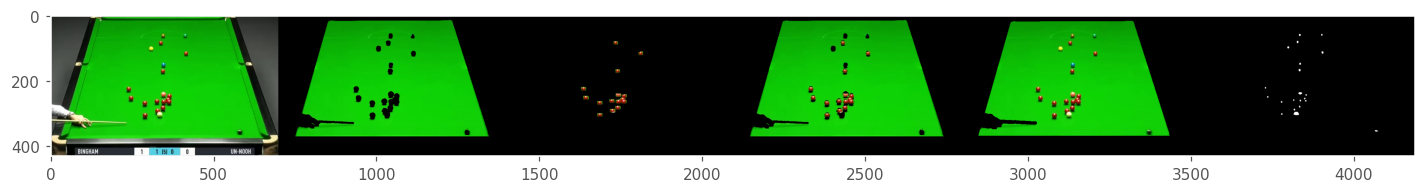

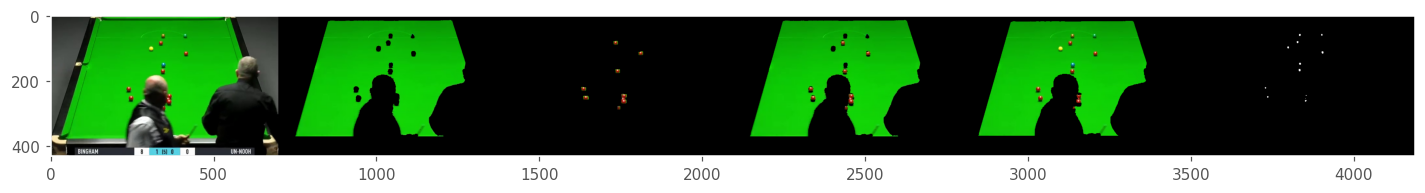

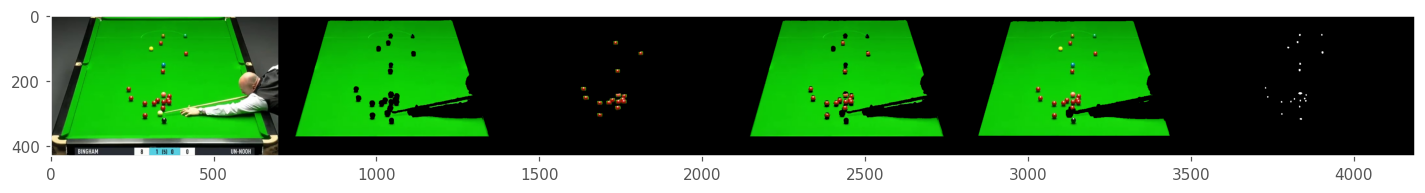

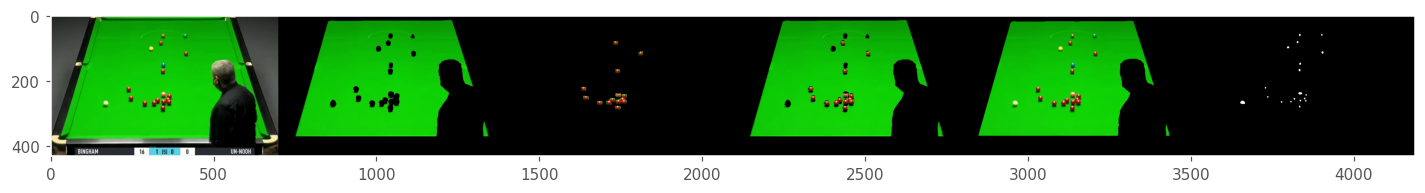

In [5]:
# oblicz maskę wnętrza stołu przez progowanie
def extract_table(h, s, v, mask):
    return ((110/2 < h) & (h < 140/2) & (v > 130) & (s > 180) & mask).astype(u8)

# oblicz maskę czerwonych bil przez progowanie i drobne operacje morfologiczne
def extract_red_balls(h, s, v, mask):
    reds = (((h < 40/2) | (340/2 < h)) & (v > 100) & (s > 150) & mask).astype(u8)
    reds = erode(reds, 3, 1)
    reds = dilate(reds, 3, 3)
    return reds

def table_with_balls(table):
    # find contour of everything *outside* the table (humans, etc.)
    mask = np.zeros_like(table)
    for c in find_contours(table):
        cv.drawContours(mask, [c], -1, 1, -1, 8)
    mask = erode(mask, 3, 2)
    return mask

# końcowa maska bil
def ball_mask(img, mask):
    img = gaussian_blur(img, k=5)
    img = sharpen(img)
    h, s, v = channels(cv.cvtColor(img, cv.COLOR_BGR2HSV))
    
    table = extract_table(h, s, v, mask)
    reds = extract_red_balls(h, s, v, mask)
    table2 = table_with_balls(table | reds)
    
    balls = cv.threshold(s, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1] * table2
    bh = balls.shape[0]//2
    balls[:bh,:] = dilate(balls[:bh,:], k=3, iters=1)
    return balls, table, reds, table2

for sample in samples:
    balls, table, reds, table2 = ball_mask(sample, mask)
    cv_imshow(np.hstack([sample, sample*stack3(table), sample*stack3(reds), sample*stack3(table | reds), sample*stack3(table2), stack3(balls)]))
    plt.show()

### Zebranie pozycji i kolorow bil w klatkach filmu

- Dla każdej klatki filmu obliczamy maskę bil i znajdujemy kontury:
- Filtrujemy kontury po minimalnej wielkości, krągłości i proporcji pola do pola wypukłego kształtu
- Dla każdego akceptowalnego konturu bili:
    - Zapisujemy centroid (4 piksele niżej niż odbija się światło)
    - Zapisujemy średnie wartości kanałów RGB (maska z promieniem 3 wokół centroidu; obrazek uprzednio rozmyty Gaussowsko 5x5) 

In [6]:
def filter_contours(contours):
    filtered = []
    for c in contours:
        M = cv.moments(c)
        xr, yr, w, h = rect = cv.boundingRect(c)
        r = (w+h)/4
        
        a_star = pi*r**2
        a = cv.contourArea(c)
        circ = 1 - abs(a - a_star)/a_star
        
        hull = cv.convexHull(c)
        hull_area = cv.contourArea(hull)
        if hull_area < EPS: continue
        solidity = float(a)/hull_area
        if solidity < 0.8: continue
        if circ < 0.3: continue
        if a < 4: continue
        if M['m00'] < EPS: continue
        x = int(M['m10'] / M['m00'])
        y = int(M['m01'] / M['m00'])
        y += 4
        filtered += [(x, y, c)]
    return filtered
    
def detect_balls(img, mask):
    bin = ball_mask(img, mask)[0]
    contours = find_contours(bin)
    contours = filter_contours(contours)
    
    res = img.copy()
    pts = []
    for x, y, c in contours:
        pts.append((x, y))
    return np.array(pts)
    
def collect_frames(path, limit=None):
    capture = cv.VideoCapture(path)
    time_balls = []
    total = int(capture.get(cv.CAP_PROP_FRAME_COUNT))
    bar = tqdm(total=limit or total)
    i = 0
    while capture.isOpened():
        _, img = capture.read()
        if img is None: break
        img = crop_frame(img)
        img = gaussian_blur(img, k=5)
        b, g, r = channels(img)
        balls = []
        for x, y in detect_balls(img, mask):
            msk = np.zeros_like(b, u8)
            cv.circle(msk, (x, y), 3, 1, -1)
            msk = msk == 1
            bb = int(np.mean(b, where=msk))
            bg = int(np.mean(g, where=msk))
            br = int(np.mean(r, where=msk))
            balls.append((x, y, bb, bg, br))
        time_balls.append(balls)
        bar.update(1)
        i += 1
        if limit is not None and i > limit: break
    bar.close()
    capture.release()
    return time_balls

frames_balls = collect_frames(PATH, limit=1300)

  0%|          | 0/1300 [00:00<?, ?it/s]

# Klasyfikacja koloru

Do obliczania punktacji oraz obsługi specjalnego zachowania czarnej bili przygotowaliśmy procedury mapujące średni kolor bili na etykietę koloru.

Dwie procedury: jedna do wykrywania czarnej bili, druga wolniejsza do wszystkich kolorów. Parametry dobraliśmy eksperymentalnie.

Przy klasyfikacji kolorów kluczowy jest komponent H w przestrzeni HSV.

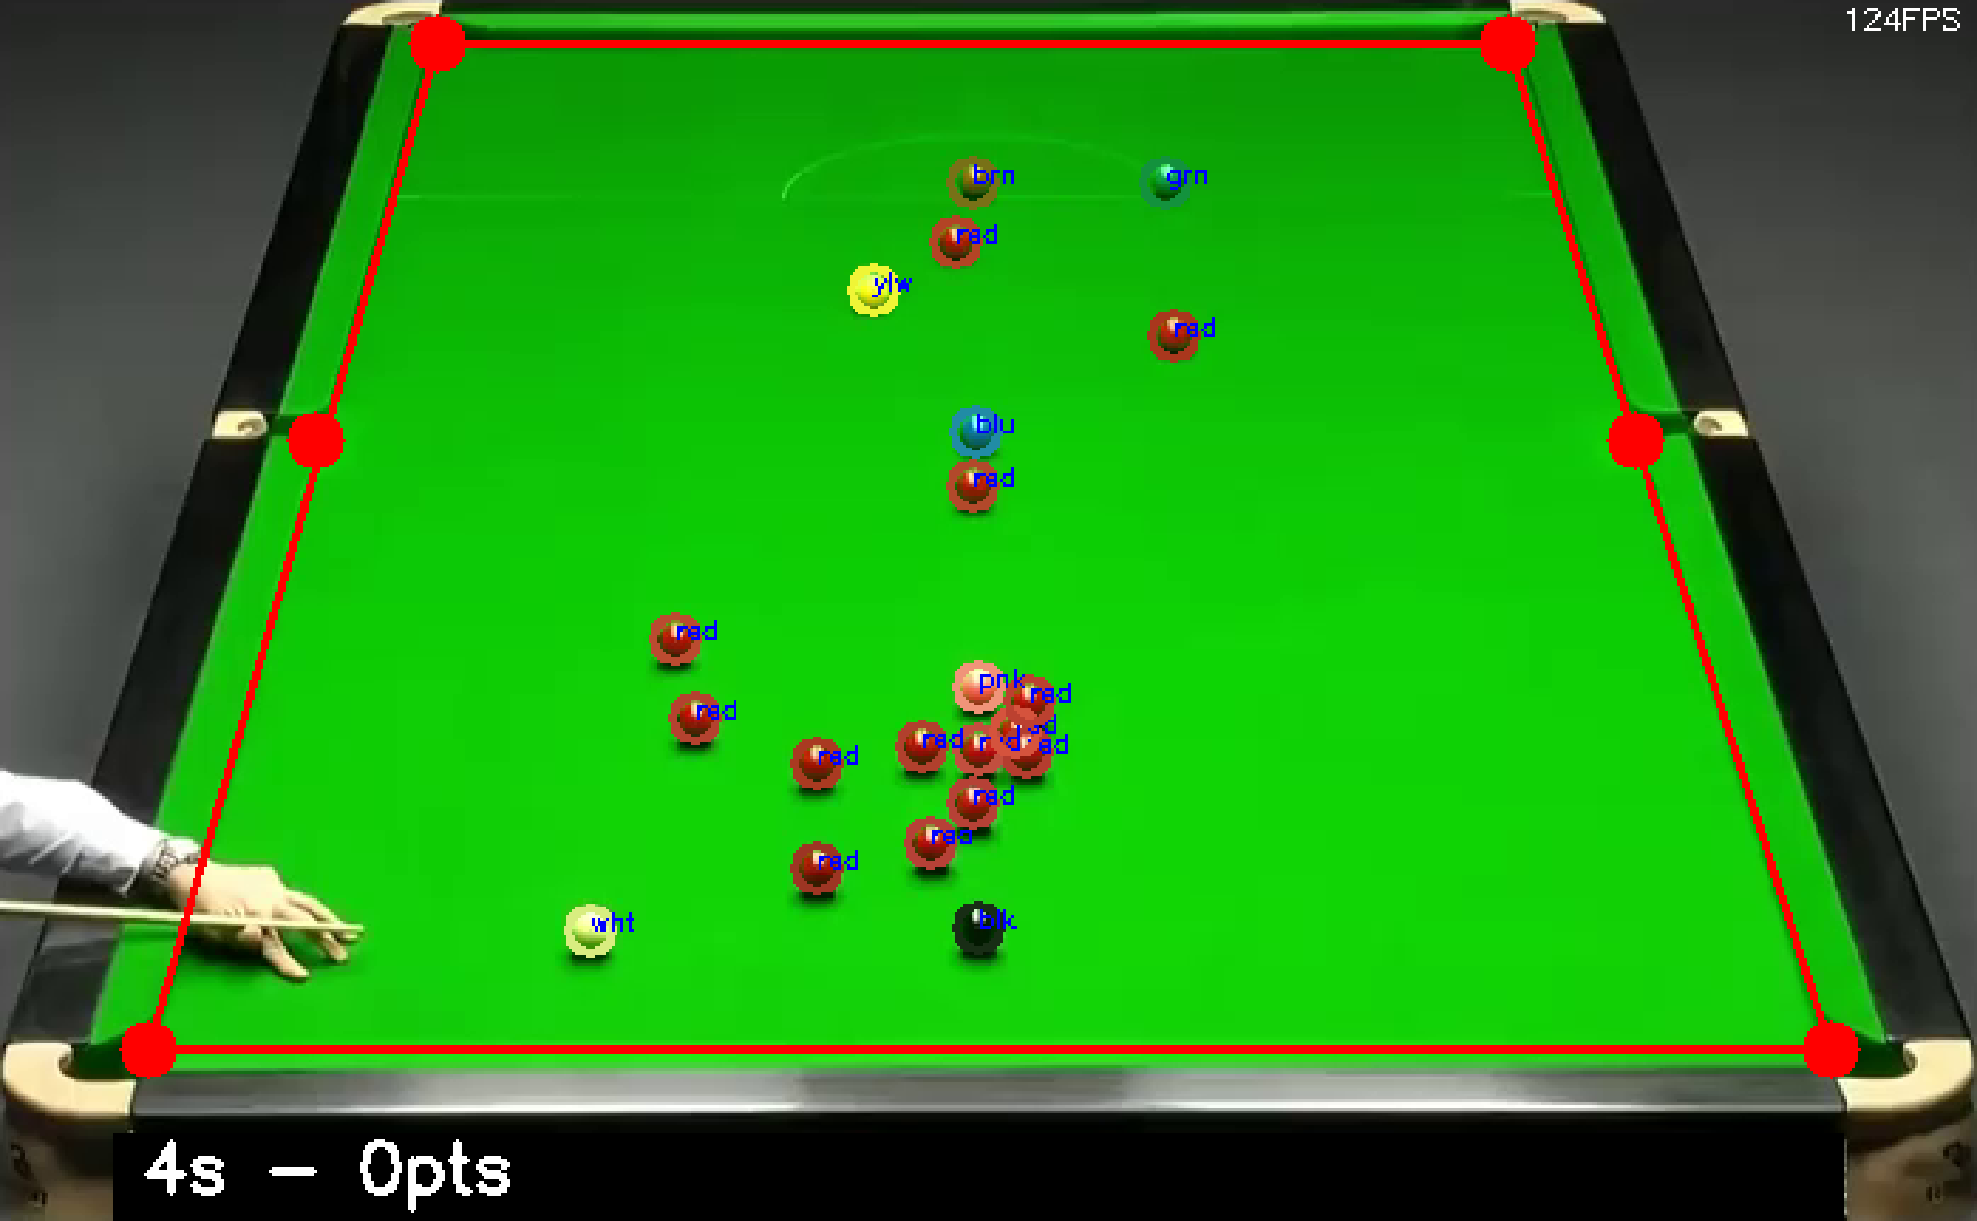

In [7]:
def classify_color(r, g, b):
    h, s, v = colorsys.rgb_to_hsv(r/255, g/255, b/255)
    h *= 360
    if  40 <= h <  85 and s > .6:
        return 'ylw' if v > .6 else 'brn'
    if   0 <= h <  40 and v > .5:
        return 'red' if s > .5 else 'pnk'
    if  85 <= h < 170 and s > .5 and v > .5: return 'grn'
    if 170 <= h < 252 and s > .5 and v > .5: return 'blu'
    if v <= .4: return 'blk'
    return 'wht'
    #assert False, f'unknown hsv color: ({h}, {s}, {v})'
    
def is_black(r, g, b):
    return (r < 55) & (g < 55) & (b < 55)

# Identyfikacja bil 

Nadajemy bilom unikalne identyfikatory, aby uspójnić miejsce składowania ich stanu (czy w dziurze), pozycji oraz przemieszczeń.

Algorytm przechowuje mapę identyfikator -> ostatnia znana pozycja i kolor bili.

Działanie algorytmu dla każdej klatki:
- dla każdej wykrytej bili:
- wyklucz bile:
    - które mają już przypisane id
    - których odległość euklidowska średniego koloru (RGB) jest większa od `max_color_dist`
    - które są oddalone o więcej niż `max_space_dist` (nie dotyczy czarnej bili, która może być wyciągnięta przez sędziego)
- jeśli znaleziono pasującą bilę, przypisz id najbliższej (w przestrzeni) bili do wykrytej bili
- jeśli nie znaleziono dopasowania utwórz nowe id
- zaktualizuj pozycję i kolor dla id 

Algorytm może działać w czasie rzeczywistym

Efekt algorytmu:

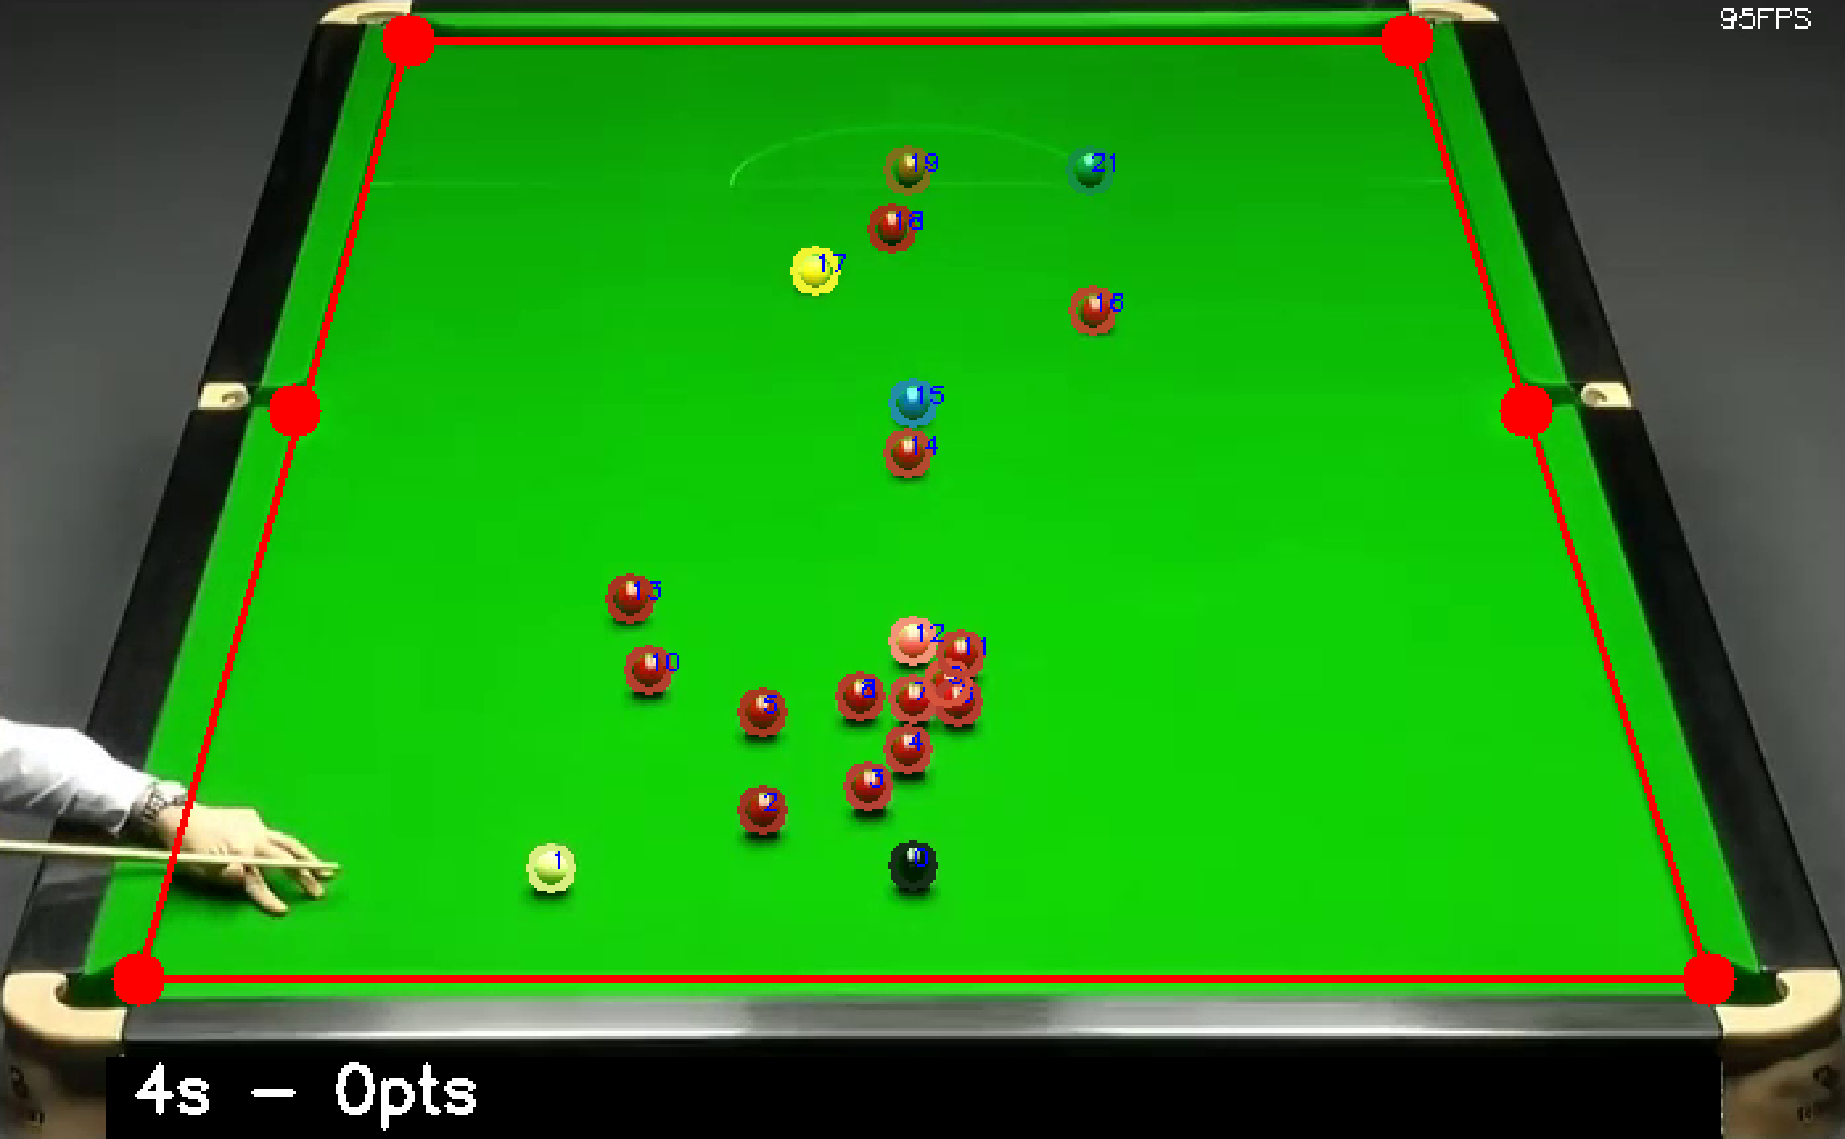

In [8]:
max_space_dist = 90
max_color_dist = 0.4*255

def identify_balls(balls):
    frames = []
    
    #colors = dict(wht=0, blk=1, ylw=2, grn=3, brn=4, blu=5, pnk=6)
    reds = dict()
    
    for i in tqdm(range(len(balls))):
        frames.append([])
        assigned = set()
        
        # find closest acceptable id in ids
        for ball in balls[i]:
            x1, y1, b1, g1, r1 = ball
                
            col = classify_color(r1, g1, b1)
            if col == 'blk':
                frames[i].append((-1, *ball))
                continue
            #    continue
            #else:
            #    continue
                
            idxs = np.array([k for k in reds if k not in assigned])
            x2, y2, b2, g2, r2 = np.array([reds[k] for k in idxs]).reshape(-1, 5).T
            dist = np.sqrt((x1-x2)**2 + (y1-y2)**2)
            cdist = np.sqrt((r1-r2)**2 + (g1-g2)**2 + (b1-b2)**2)
            mask = (dist < max_space_dist) & (cdist < max_color_dist)
            dist = dist[mask]
            idxs = idxs[mask]
            id = idxs[np.argmin(dist)] if len(idxs) > 0 else len(reds) + 1 
            assigned.add(id)
            reds[id] = ball
            frames[i].append((id, *ball))
            
    return frames

id_balls = identify_balls(frames_balls)

  0%|          | 0/1301 [00:00<?, ?it/s]

# Maszyna stanu gry

- Korzysta z deskryptorów bil obliczonych w poprzednich krokach
- Zapisuje historię pozycji i wektorów przemieszczeń bil
- Zapisuje ostatni kolor bil
- Zapisuje stan bil (czy wpadła do dziury)
- Rysuje linie łączące ostatnie `m` pozycji bili (w jej kolorze)
- Zaznacza bile na filmie 
- Jeśli czarna bila była w dziurze ale nagle się pojawiła w punkcie startowym, to kasuje jej historię i wyciąga ją z dziury
- Dla każdej bili nie w dziurze
    - Policz `v0`, czyli średnią ostatnich `shift` wektorów przemieszczenia
    - Policz `v1`, czyli średnią `window` wektorów przemieszczenia poprzedzających `shift`
    - Jeśli wektor `v0` się zwiększył od pomijalnej wartości do `v1`, to bila została wprawiona w ruch
    - Jeśli kąt wektora się zmienił:
        - Jeśli obok jest bila która została ostatnio ruszona lub zmienił się jej kierunek wektora, to te bile się zderzyły
        - Inaczej bila odbiła się od stołu
- Dla każdej dziury, dla każdej bili nie w dziurze, sprawdza czy bila nie znalazła się blisko dziury ze średnim wektorem prędkości wskazującym na to że do tej dziury wpadnie
    - Jeśli tak, to bila wpadła do tej dziury -> naliczamy za nią punkty według koloru

In [9]:
# id bili -> historia pozycji
pos_hist = defaultdict(list)
# id bili -> historia wektorów
vec_hist = defaultdict(list)
# zbiór bil w dziurach
in_hole = set()
# zbiór bil w ruchu
in_motion = set()
# id bili -> kolor BGR
col = dict()
# historia animacji dziury
hole_hl = list()
# numer klatki
frame_n = 0
# historia wiadomości
messages = []
window = 3
shift = 2
# punktacja
color_points = dict(red=1, ylw=2, grn=3, brn=4, blu=5, pnk=6, blk=7)
# aktualna liczba punktów
points = 0
framerate = 1/40
fps_hist = []
last_seen = defaultdict(int)
max_collide_dist = 35

@playnow(path=PATH)
def demo(img):
    global frame_n, pos_hist, vec_hist, in_hole, col, message, messages, points, fps_hist, in_motion, last_seen
    if frame_n == 0: frame_n = 1; return
    t_start = time()
    img = crop_frame(img)
    balls = id_balls[frame_n]
    
    # reset przy następnym ujęciu w filmie
    if not balls:
        pos_hist = defaultdict(list)
        vec_hist = defaultdict(list)
        col = dict()
        in_hole = set()
        points = 0
        messages = []
    
    # rysowanie śladów ruchu
    for id in pos_hist:
        if id in in_hole: continue
        if frame_n - last_seen[id] > 100: continue
        hist = pos_hist[id]
        m = 50
        for (x1, y1), (x2, y2) in zip(hist[-m:-1], hist[-m+1:]):
            cv.line(img, (x1, y1), (x2, y2), col[id], 1)
            
    # rysowanie i śledzenie bil
    for id, x, y, b, g, r in balls:
        if is_black(r, g, b) and id in in_hole and dist(x, black_x, y, black_y) < 50:
            vec_hist[id] = []
            pos_hist[id] = []
            in_hole.remove(id)
            messages.append('put back blk')
            
        if not pos_hist[id]: pos_hist[id].append((x, y))
        
        x_last, y_last = pos_hist[id][-1]
        vec_hist[id].append((x-x_last, y-y_last))
        pos_hist[id].append((x, y))
        col[id] = c = b, g, r
        last_seen[id] = frame_n
        
        cv.circle(img, (x, y), 8, c, 2)
        # rysuj identyfikator
        cv.putText(img, str(id), (x, y), FONT, 0.3, BLU, 1)
        # rysuj klasyfikację koloru
        #cv.putText(img, classify_color(r,g,b), (x, y), FONT, 0.3, BLU, 1)
        
        if len(vec_hist[id]) >= window:
            v1 = np.array(vec_hist[id][-window-shift:-shift]).reshape(-1, 2).mean(0)
            v2 = np.array(vec_hist[id][-shift:]).reshape(-1, 2).mean(0)
            cv.line(img, (x, y), (int(x+v1[0]), y+int(v1[1])), BLU, 1)
            cv.line(img, (x, y), (int(x+v2[0]), y+int(v2[1])), RED, 1)
            
    did_move = set()
    dir_changed = set()
    
    # śledzenie wektorów ruchu
    for id in vec_hist:
        if len(vec_hist[id]) < window: continue
        v1 = np.array(vec_hist[id][-window-shift:-shift]).reshape(-1, 2).mean(0)
        v2 = np.array(vec_hist[id][-shift:]).reshape(-1, 2).mean(0)
        m1, m2 = norm(v1), norm(v2)
        if m1 < .5 and m2 > .5:
            in_motion.add(id)
            #messages.append(f'{id} was put into motion')
            continue
        if m2 < .5:
            if id in in_motion:
                in_motion.remove(id)
            continue
            
        dot = np.arccos(np.dot(v1, v2)/(m1*m2))
        if dot > 0.01:
            dir_changed.add(id)
            #messages.append(f'direction of {id} changed')
            
    # wykrywanie kolizji
    for id1, x1, y1, b1, g1, r1 in balls:
        for id2, x2, y2, b2, g2, r2 in balls:
            if id1 == id2: continue
            if dist(x1, x2, y1, y2) > max_collide_dist: continue
            if (id1 in in_motion and id2 in dir_changed) or (id1 in did_move and id2 in in_motion):
                cv.circle(img, (x1+(x2-x1)//2, y1+(y2-y1)//2), 4, BLU, -1)
                c1 = classify_color(r1, g1, b1)
                c2 = classify_color(r2, g2, b2)
                msg1 = f'{c1} ({id1}) collided with {c2} ({id2})'
                msg2 = f'{c2} ({id2}) collided with {c1} ({id1})'
                # do not print duplicate collisions
                last_msgs = messages[-10:]
                if msg1 not in last_msgs and msg2 not in last_msgs:
                    messages.append(msg1)
                
    
    # wykrywanie wpadnięcia do dziury
    hl = []
    for hole in HOLES:
        hx, hy = hole
        for id, x, y, _, _, _ in balls:
            v1 = np.array(vec_hist[id][-3:]).reshape(-1, 2).mean(0)
            v2 = np.array([hx-x, hy-y])
            m1, m2 = norm(v1), norm(v2)
            dot = np.arccos(np.dot(v1, v2)/(m1*m2))
            
            if id in in_hole:
                continue
            if dot < 0.02*tau and dist(hx, x, hy, y) < 50:
                b, g, r = col[id]
                name = classify_color(r, g, b)
                if name == 'wht':
                    continue
                pts = color_points[name]
                points += pts
                in_hole.add(id)
                messages.append(f'{name} fell into hole (+{pts}pts)')
                hl.append(hole)
    hole_hl.append(hl)
    
    # rysowanie statusu i inne mniej istotne rzeczy
    status = ' '.join([f'{frame_n/30:.0f}s - {points}pts'])
    if not balls: status += ' - new clip'
    draw_overlay(img, status)
    for i, message in enumerate(messages[-10:]):
        cv.putText(img, message, (5, (i+1)*12), FONT, 0.35, WHT, 1)
    
    for holes in hole_hl[-60:]:
        for hole in holes:
            cv.circle(img, hole, 8, BLU, -1)
            
    frame_n += 1
    fps_hist.append(time() - t_start)
    cv.putText(img, f'{1/np.mean(fps_hist[-20:]):.0f}FPS', (650, 10), FONT, 0.35, WHT, 1)
    cv.imshow('frame', img)
    t_sync = framerate - (time() - t_start)
    if t_sync > 0: sleep(t_sync)

<ipython-input-9-f6dfb1ce695a>:130: RuntimeWarning: invalid value encountered in double_scalars
  dot = np.arccos(np.dot(v1, v2)/(m1*m2))
<ipython-input-9-f6dfb1ce695a>:100: RuntimeWarning: invalid value encountered in double_scalars
  dot = np.arccos(np.dot(v1, v2)/(m1*m2))
